In [44]:
!pip install transformers==2.6.0
!pip install seqeval[gpu]
!pip install seqeval[cpu]
!pip install tensorflow==2.1
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [45]:
data = pd.read_excel('tagged_dataset_final.xlsx', encoding="latin1").fillna(method="ffill")
data.tail(10)

,Unnamed: 0,sentence_id,word,tag
265470,265470,18412,could,O
265471,265471,18412,distinguish,O
265472,265472,18412,ctcl,O
265473,265473,18412,from,O
265474,265474,18412,benign,O
265475,265475,18412,skin,O
265476,265476,18412,diseases,O
265477,265477,18412,like,O
265478,265478,18412,psoriasis,O
265479,265479,18412,url,O


In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [47]:
getter = SentenceGetter(data)

sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['sofosbuvir',
 'and',
 'velpatasvir',
 'for',
 'hcv',
 'genotype',
 '1',
 '2',
 '4',
 '5',
 'and',
 '6',
 'infection',
 'nejm',
 'url']

In [48]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['B-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'O', 'O']


In [49]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)

{'B-AT': 0, 'I-AT': 1, 'O': 2, 'PAD': 3}


In [50]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.5.0+cu101'

In [51]:
MAX_LEN = 100
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        word_string = str(word)
        tokenized_word = tokenizer.tokenize(word_string)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [0]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

#print(tokenized_texts[1])
#print(labels[1])

In [54]:
print(tokenized_texts[2])
print(labels[2])

['rt', 'ne', '##jm', 'presented', 'monday', 'at', 'liver', '##15', 'so', '##fo', '##sb', '##u', '##vir', 'and', 've', '##lp', '##ata', '##s', '##vir', 'for', 'hc', '##v', 'gen', '##otype', '##s', '1', '2', '4', '5', 'and', '6', 'infection', 'as', '##tral', '##1', 'ur', '##l']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AT', 'B-AT', 'B-AT', 'B-AT', 'B-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'I-AT', 'O', 'O', 'O', 'O', 'O']


In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != tag2idx["PAD"]) for i in ii] for ii in input_ids]


In [0]:
tr_inputs, vall_inputs, tr_tags, vall_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.2)

val_inputs, test_inputs, val_tags, test_tags = train_test_split(vall_inputs, vall_tags, 
                                                            random_state=2018, test_size=0.5)

tr_masks, vall_masks, nrv1, nrv2 = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

val_masks, test_masks, _, _ = train_test_split(vall_masks, nrv2,
                                             random_state=2018, test_size=0.5)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
test_tags = torch.tensor(test_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)


train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [57]:
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup


transformers.__version__

'2.6.0'

In [0]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.cuda();

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,        
    lr=3e-5,
    eps=1e-8
)


epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    
    num_training_steps=total_steps
)

In [0]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [61]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    
    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()    
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        #torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        #scheduler.step()
        
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    
    # ========================================
    #               Validation
    # ========================================

    
    # evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    
    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p in predictions for p_i in p]
    valid_tags = [tag_values[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.08078272604745149
Validation loss: 0.04721221080499476
Validation Accuracy: 0.9829937880324545


Epoch:  33%|███▎      | 1/3 [02:24<04:48, 144.23s/it]

Validation F1-Score: 0.8471835652750165

Average train loss: 0.03180151605279611
Validation loss: 0.033600771590938855
Validation Accuracy: 0.9881795131845844


Epoch:  67%|██████▋   | 2/3 [04:48<02:24, 144.16s/it]

Validation F1-Score: 0.8826450601150027

Average train loss: 0.01882824462403113
Validation loss: 0.030908744220204395
Validation Accuracy: 0.9902950684584177


Epoch: 100%|██████████| 3/3 [07:12<00:00, 144.16s/it]

Validation F1-Score: 0.90154896298241



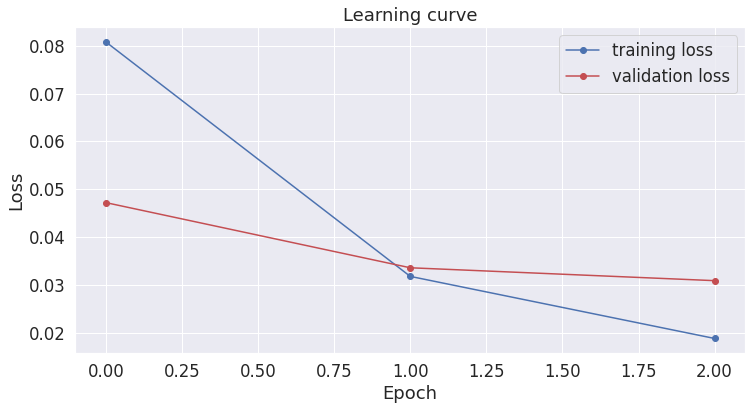

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [63]:
    # ========================================
    #               Test
    # ========================================

model.eval()
predictions , true_labels = [], []
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
        
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
  logits = outputs[1].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
          predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
  true_labels.append(label_ids)
        
pred_tags = [tag_values[p_i] for p in predictions for p_i in p]
valid_tags = [tag_values[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
print("Test F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
print()

Test F1-Score: 0.911326183625425

